## Distributed Conditional GAN (discGAN)
### GANs with and without distribution
#### Diana and David

**This notebook contains the discGAN code that our team put together along with several implementations of it.**

**The code generalizes tabular output for the conditional GAN and allows for distribution.**

In [1]:
# import packages

import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
!pip install table_evaluator # install table evaluator

#https://pypi.org/project/table-evaluator/
# used to evaluate the performance of the tabular data generation vs the true data

from table_evaluator import load_data, TableEvaluator # import functions

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
# if connecting to Colab, connect to Google Drive with this code:

#from google.colab import drive
#drive.mount('/content/drive')

## Create the cGAN class along with some important functions to be used throughout the notebook:

In [4]:
# the skeleton of this code is derived from the following tutorial:
# https://keras.io/examples/generative/conditional_gan/#interpolating-between-classes-with-the-trained-generator

# info on distributing across GPUs: https://www.tensorflow.org/tutorials/distribute/custom_training

# create the conditional GAN

class ConditionalGAN(keras.Model):
    def __init__(self, noise_dim=50, 
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = False, distribute = False): # distributed flag can be 'G', 'D', or 'both' for distributing the generator, discriminator, or both

        super(ConditionalGAN, self).__init__()
        self.noise_dim = noise_dim
        self.data_shape = data_shape # output shape of the generator and goes to discriminator
        self.num_classes = num_classes # number of classes across the categorical features
        self.d_optimizer = tf.keras.optimizers.Adam(d_learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(g_learning_rate)
        self.batch_size = batch_size
        self.start_epoch = start_epoch
        self.verbose = verbose
        self.distribute = distribute

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

        # add number of class labels to the input channels for generator
        self.g_dim = self.noise_dim + self.num_classes

        # add the number of class labels to the input to the discriminator
        self.d_dim = self.data_shape + self.num_classes

        if (self.verbose):
            print("Generator input dim: ", self.g_dim)
            print("Dicrimination input dim: ", self.d_dim)

        # build generator and discriminator
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def build_generator(self):
        "Build the generator model"
        inputs = Input(shape=(self.g_dim,))
        hidden = Dense(64)(inputs) # 128
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden) # added 
        hidden = Dense(64)(hidden) # added 
        hidden = LeakyReLU(alpha=0.2)(hidden)
        
        output = Dense(self.data_shape, activation="sigmoid")(hidden)
        #output = Dense(self.data_shape, activation="linear")(hidden)
        
        # add the ability to distribute the generator
        
        if self.distribute == False: 
          generator = Model(inputs=inputs, outputs=output, name="generator")

        elif self.distribute == 'G' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():

            generator = Model(inputs=inputs, outputs=output, name="generator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            generator = Model(inputs=inputs, outputs=output, name="generator")

        generator.summary()
        return generator


    def build_discriminator(self):
        "build the discriminator model"
        d_inputs = Input(shape=(self.d_dim,))
        h = Dense(64, input_shape=(self.g_dim,))(d_inputs) 
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32 # added
        h = LeakyReLU(alpha=0.2)(h) # added
        h = Dropout(0.1)(h) # added
        h = Dense(1, activation="sigmoid")(h)
        
        # add the ability to distribute the discriminator
        
        if self.distribute == False:
          discriminator = Model(d_inputs, h, name="discriminator")

        elif self.distribute == 'D' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():
            discriminator = Model(d_inputs, h, name="discriminator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            discriminator = Model(inputs=inputs, outputs=output, name="generator")      

        discriminator.summary()
        return discriminator

    def compile(self, loss_fn):
        super(ConditionalGAN, self).compile()
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_ages, one_hot_labels = data
        real_ages = tf.cast(real_ages, tf.float32)
        #print("real_ages:", real_ages[0:2])

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the true data. This is for the discriminator.
        one_hot_labels = one_hot_labels[:, None]
        print("one_hot_labels1:", one_hot_labels[0:2])

        one_hot_labels = tf.repeat(one_hot_labels, repeats=[1])
        print("one_hot_labels2:", one_hot_labels[0:2])

        one_hot_labels = tf.reshape(one_hot_labels, (-1, self.num_classes))
        one_hot_labels = tf.cast(one_hot_labels, tf.float32)
        print("one_hot_labels3:", one_hot_labels[0:2])

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_ages)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake.
        generated_continuous = self.generator(random_vector_labels)
        generated_continuous= tf.cast(generated_continuous, tf.float32)

        # combine generated output and truth
        fake_ages_and_labels = tf.concat([generated_continuous, one_hot_labels], -1)
        real_ages_and_labels = tf.concat([real_ages, one_hot_labels], -1) 
        combined_ages = tf.concat([fake_ages_and_labels, real_ages_and_labels], axis=0)

        # Assemble labels discriminating real from fake. 1 == fake, 0 == real
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        #labels = tf.random.shuffle(labels, seed = 24)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_ages)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.t
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_ages = self.generator(random_vector_labels)
            fake_ages_and_labels = tf.concat([fake_ages, one_hot_labels], -1)
            predictions = self.discriminator(fake_ages_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
    
    #######################
    
    ## function graveyard
    
    # this function creates a list of arrays with every possible position of one 1 and remaining 0s
    '''
    def create_zeros(size):
        
      a = []

      for i in range(size):
        b = [0] * size
        b[i] = 1
        a.append(b)
      return a
      '''


    '''def generate(self, n=1000, one_hot_label=[1., 0., 0., 0., 0., 0., 1., 0.]):
        """Generate n ages for a class"""
        print("Generating: ", n, " ages for unit type: ", one_hot_label)
        input_noise = tf.random.normal((n, self.noise_dim), 0, 1)
        random_vector_labels = tf.concat([input_noise, one_hot_label], axis=1)

        ages = self.generator(random_vector_labels)

        return ages.numpy()'''
    
    

## Function used to generate data and display statistics on the generated output:

In [5]:
def generate_table(df, features = ['ethnicity', 'gender'], cont_feats = ['age'], n = None): # n is number of values to generate; if None, then the count for each category in the true data is produced
    
  i = 0 # iterator 
  l = [] 

  encoder = OneHotEncoder(handle_unknown='ignore', categories = 'auto') # OHE sklearn initiate
  encoder.fit_transform(df_feats[features]).toarray()
    
  encoder_df = pd.DataFrame(encoder.fit_transform(df_feats[features]).toarray(), columns = encoder.get_feature_names(features))

  # merge one-hot encoded columns back with original DataFrame
  final_df = df_feats.join(encoder_df)

  for j in np.unique(encoder.fit_transform(df_feats[features]).toarray(), axis=0): # iterate through the possible combos of OHE labels


    """Generate n elements for a class"""
    print('_'*30)
    
    if n != None:
        print("Generating: ", n, " data elements with categorical vars: ", 
              df.groupby(features).count().iloc[i].name)

    else:
        print("Generating: ", df.groupby(features).count().iloc[i][0], " data elements with categorical vars: ", 
              df.groupby(features).count().iloc[i].name)
    
    if n == None:
        one_hot_labels = tf.repeat([j],df.groupby(features).count().iloc[i][0], axis=0)
        input_noise = tf.random.normal((df.groupby(features).count().iloc[i][0], cgan.noise_dim), 0, 1)
        
    else:
        one_hot_labels = tf.repeat([j],n, axis=0)
        input_noise = tf.random.normal((n, cgan.noise_dim), 0, 1)
        
    random_vector_labels = tf.concat([input_noise, tf.cast(one_hot_labels, dtype=tf.float32)], axis=1)
    
    gen_data = cgan.generator(random_vector_labels) # call the generator from cgan

    f_dict = {} # dictionary to hold info cat vars
    for m in range(len(features)):
      f_dict[m] = df.groupby(features).count().iloc[i].name[m] # number of examples of each feature in the true data


    # create query to specify each possibility of cat combonations
    q = ''
    for m in range(len(features)):
      q += features[m] + " == '" + f_dict[m] +"' &"
    q = q[:-1]

    df_feats_class = final_df.query(q)

    df_temp = pd.DataFrame(columns = cont_feats + features)

    di_cont = {} # dictionary to hold continuous vars

    if i == 0:
      df_age_eth = pd.DataFrame(columns = cont_feats + features)

    k = 0
    for c in cont_feats:

      print(' ')
    
      if n == None:
    
         input_noise = tf.random.normal((df.groupby(features).count().iloc[i][0], cgan.noise_dim), 0, 1)
        
      else:
        
         input_noise = tf.random.normal((n, cgan.noise_dim), 0, 1)
      
      random_vector_labels = tf.concat([input_noise, tf.cast(one_hot_labels, dtype=tf.float32)], axis=1)
      
      gen_data = cgan.generator(random_vector_labels)
        
      # scale data  

      mean_filtered = df[c].mean()
      std_filtered =  df[c].std()
      min_filtered =  df[c].min()
      max_filtered =  df[c].max()

      scaled_filtered = [(x - min_filtered)/(max_filtered - min_filtered) for x in df[c]]
      scaled_filtered = [0 if math.isnan(x) else x for x in scaled_filtered]
      all = np.reshape(scaled_filtered, (-1, 1))
      di_cont[k] = all
      inv_gen_ages = [(val * (max_filtered-min_filtered)) + min_filtered for val in gen_data.numpy().flatten()]
      df_temp[c] = inv_gen_ages
    
      # show some stats for the generated and real data

      print("Generated statistics for continuous var <", c, ">:")
      print("min: ", np.min(inv_gen_ages))
      print("mean: ", np.mean(inv_gen_ages))
      print("max: ", np.max(inv_gen_ages))
      print("stdv: ", np.std(inv_gen_ages))
      print(' ')

      print("Statistics of real data for continuous var <", c, ">:")
      print("min: ", np.min(df_feats_class[c]))
      print("mean: ", np.mean(df_feats_class[c]))
      print("max: ", np.max(df_feats_class[c]))
      print("stdv: ", np.std(df_feats_class[c]))
      k += 1

    for f in range(len(features)): # add in the generated categorical data for each generated data
      df_temp[features[f]] = f_dict[f]

    df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
    i+=1
    print(' ')

  return df_age_eth, final_df


## Data Prep: Create TF Dataset

In [6]:
features = ['ethnicity', 'gender', 'hospitaldischargestatus'] # categorical features

In [7]:
cont_feats = ['hospitaldischargeoffset']#, 'age'] # continuous features

In [8]:
df = pd.read_csv('/sfs/qumulo/qhome/dmf4ns/DS6050/data_3D_pasthistories.csv')

feats_np = df[cont_feats + features].to_numpy()
print('length: ', len(feats_np))
print(feats_np[0:5])


# create a dictionary of feature arrays for all features we will generate

di_f = {}
i = 0
for f in cont_feats + features:
  di_f[i] = np.asarray(feats_np[:,i].flatten().tolist()).flatten()
  i += 1

# create DF from the arrays above. These are the true data from which we will create synthetic data
    
df_feats = pd.DataFrame(zip(*di_f.values()), columns=cont_feats + features)
print(df_feats.shape)
print(df_feats.groupby(features).count())

# create data set
print("==" * 30)
print("Data Info:")

try:
  df_feats_filtered = df_feats.query("age < 90") # filter for only age <90 if age is the cont var

except:
  df_feats_filtered = df_feats

for i in features:
  df_feats_filtered[i+'_code'] = df_feats_filtered[i].astype('category').cat.codes # set up dummy DF columns

print(df_feats_filtered.groupby('ethnicity').count())

di_cont = {}
i = 0

for c in cont_feats: # print stats for each continues variable and save for standardizing
  mean_filtered = df_feats_filtered[c].mean()
  std_filtered =  df_feats_filtered[c].std()
  min_filtered =  df_feats_filtered[c].min()
  max_filtered =  df_feats_filtered[c].max()

  print("mean age: ", mean_filtered)
  print("std age: ", np.round(std_filtered,3))
  print("min age: ", min_filtered)
  print("max age: ", max_filtered)
    
  # standardize

  scaled_filtered = [(x - min_filtered)/(max_filtered - min_filtered) for x in df_feats_filtered[c]]
  scaled_filtered = [0 if math.isnan(x) else x for x in scaled_filtered] # replace missing with 0 (the mean)
  all = np.reshape(scaled_filtered, (-1, 1))
  di_cont[i] = all
  i+=1

# dictionary for cat vars
di = {}
i = 0
for f in features: # dummy encode the categorical features
  di[i] = keras.utils.to_categorical(df_feats_filtered[f + '_code'], df_feats_filtered[f + '_code'].max()+1)
  i += 1

all = np.concatenate(list(di_cont.values()), axis = 1) # concat the continuous variable arrays
all_labels = np.concatenate(list(di.values()), axis = 1) # concat the categoritcal variable arrays

print(f"Shape of continuous var(s): {all.shape}")

print(f"Shape of labels: {all_labels.shape}")

# Create tf.data.Dataset.

dataset = tf.data.Dataset.from_tensor_slices((all, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64)


length:  2537
[[3962 'Hispanic' 'Female' 'Alive']
 [1592 'Caucasian' 'Male' 'Alive']
 [4370 'Caucasian' 'Female' 'Alive']
 [3583 'Caucasian' 'Male' 'Alive']
 [3583 'Caucasian' 'Male' 'Alive']]
(2537, 4)
                                                 hospitaldischargeoffset
ethnicity        gender hospitaldischargestatus                         
African American Female Alive                                         99
                        Expired                                        3
                        nan                                            2
                 Male   Alive                                        158
                        Expired                                       12
                        nan                                            1
Asian            Female Alive                                         12
                        Expired                                        3
                 Male   Alive                                      

2022-04-25 00:31:49.281860: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 00:31:51.580123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10788 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:85:00.0, compute capability: 3.7
2022-04-25 00:31:51.585133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10788 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:88:00.0, compute capability: 3.7


______
## Set up discGAN and run on dataset created above; distribute the discriminator

In [9]:
cgan = ConditionalGAN(noise_dim=50,
                 data_shape=len(cont_feats),
                 num_classes=all_labels[:1].shape[1], 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = True, distribute = 'D')

Generator input dim:  61
Dicrimination input dim:  12
Instructions for updating:
use distribute.MultiWorkerMirroredStrategy instead
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CommunicationImplementation.AUTO
Number of devices: 2
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 64)                832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 


In [10]:
cgan.compile(loss_fn=tf.keras.losses.BinaryCrossentropy())

In [11]:
cgan.fit(dataset, epochs=2000, verbose=True)

Epoch 1/2000
one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 11), dtype=float32)
one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 11), dtype=float32)
one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 11), dtype=float32)
one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 11), dtype=float32)
40/40 [==============================] - 3s 4ms/step - g_loss: 0.6725 - d_loss: 0.6848
Epoch 2/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.6727 - d_loss: 0.6847
Epoch 3/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.6732 - d_loss: 0.6844
Epoch 4/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.6740 - d_loss: 0.6842
Epoch 5/2000
40/40 [==============================] - 0s 4ms/step - g_loss: 0.6740 - d_loss: 0.6841
Epoch 6/2000
40/40 [============

### Generate data and evaluate synthetic output

In [24]:
df_age_eth, final_df = generate_table(df_feats, features = features, cont_feats = cont_feats)

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) 

______________________________
Generating:  99  data elements with categorical vars:  ('African American', 'Female', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  68.29900076218473
mean:  13943.662544749024
max:  59846.399141818285
stdv:  13277.214128665344
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  240
mean:  8647.10101010101
max:  51993
stdv:  7928.211868015411
 
______________________________
Generating:  3  data elements with categorical vars:  ('African American', 'Female', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  5274.383489400148
mean:  11170.354128661254
max:  15443.784548811615
stdv:  4307.254117475442
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  2093
mean:  7531.0
max:  10250
stdv:  3845.2466760924453
 
______________________________
Generating:  2  data elements with categorical vars:  ('African American', 'Female', 'n

/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular d

 
______________________________
Generating:  12  data elements with categorical vars:  ('African American', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  421.0870381735731
mean:  6245.954984845613
max:  18169.272936984897
stdv:  5689.352447617841
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  283
mean:  8830.166666666666
max:  12961
stdv:  3979.0715171870047
 
______________________________
Generating:  1  data elements with categorical vars:  ('African American', 'Male', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  2110.4154418269172
mean:  2110.4154418269172
max:  2110.4154418269172
stdv:  0.0
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  6353
mean:  6353.0
max:  6353
stdv:  0.0
 
______________________________
Generating:  12  data elements with categorical vars:  ('Asian', 'Female', 'Alive')
 
Generated statistics for continuou

/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular d

 
______________________________
Generating:  10  data elements with categorical vars:  ('Asian', 'Male', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1299.8352474393323
mean:  19683.580836677644
max:  40933.45034599304
stdv:  13450.153716699206
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  3557
mean:  7024.6
max:  14283
stdv:  3677.5833423594904
 
______________________________
Generating:  2  data elements with categorical vars:  ('Asian', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  6190.461051475257
mean:  8571.142142215744
max:  10951.82323295623
stdv:  2380.681090740487
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  901
mean:  901.0
max:  901
stdv:  0.0
 
______________________________
Generating:  767  data elements with categorical vars:  ('Caucasian', 'Female', 'Alive')
 
Generated statistics for continuous var < hospita

/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular d

 
______________________________
Generating:  8  data elements with categorical vars:  ('Caucasian', 'Female', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  361.5148119216319
mean:  15720.562823318614
max:  32532.394891873002
stdv:  13455.779075056975
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  815
mean:  9036.75
max:  31629
stdv:  13071.088724260882
 
______________________________
Generating:  937  data elements with categorical vars:  ('Caucasian', 'Male', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  101.87021349003771
mean:  10837.139160504385
max:  89339.40120512247
stdv:  11462.930313325227
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  43
mean:  9275.196371398079
max:  143016
stdv:  9779.317854477287
 
______________________________
Generating:  134  data elements with categorical vars:  ('Caucasian', 'Male', 'Expired')
 
Generated s

/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular d

 
______________________________
Generating:  30  data elements with categorical vars:  ('Hispanic', 'Female', 'Alive')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  129.20220717589837
mean:  9005.45302283571
max:  24467.481872931123
stdv:  6790.605482417016
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  239
mean:  8684.733333333334
max:  48882
stdv:  10587.250968132485
 
______________________________
Generating:  1  data elements with categorical vars:  ('Hispanic', 'Female', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  6889.477382734418
mean:  6889.477382734418
max:  6889.477382734418
stdv:  0.0
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  2234
mean:  2234.0
max:  2234
stdv:  0.0
 
______________________________
Generating:  1  data elements with categorical vars:  ('Hispanic', 'Female', 'nan')
 
Generated statistics for continuous var < hospi

/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular d

 
______________________________
Generating:  30  data elements with categorical vars:  ('Hispanic', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  315.84063245449215
mean:  8754.57684716861
max:  46244.4194380939
stdv:  8968.11853642175
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  72
mean:  10744.566666666668
max:  25659
stdv:  5955.695770623464
 
______________________________
Generating:  4  data elements with categorical vars:  ('Hispanic', 'Male', 'nan')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  994.0820130622014
mean:  8000.636680760188
max:  22998.608096048236
stdv:  8928.106562084156
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  5406
mean:  15665.0
max:  25924
stdv:  10259.0
 
______________________________
Generating:  3  data elements with categorical vars:  ('Native American', 'Female', 'Alive')
 
Generated statistics for co

/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular d

Generating:  7  data elements with categorical vars:  ('Other/Unknown', 'Male', 'Expired')
 
Generated statistics for continuous var < hospitaldischargeoffset >:
min:  1971.7671265881509
mean:  12280.077578153994
max:  42319.86665508151
stdv:  13851.112204421745
 
Statistics of real data for continuous var < hospitaldischargeoffset >:
min:  154
mean:  5394.0
max:  10198
stdv:  3725.943063747179
 


/tmp/ipykernel_31747/2841896178.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data


In [25]:
 df_age_eth.shape#tail()

(2537, 4)

**Evaluate output data**

In [26]:
df_age_eth['data'] = 'GAN'

In [27]:
final_df.head()

,hospitaldischargeoffset,ethnicity,gender,hospitaldischargestatus,ethnicity_code,gender_code,hospitaldischargestatus_code,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_Female,gender_Male,hospitaldischargestatus_Alive,hospitaldischargestatus_Expired,hospitaldischargestatus_nan
0,3962,Hispanic,Female,Alive,3,0,0,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
1,1592,Caucasian,Male,Alive,2,1,0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2,4370,Caucasian,Female,Alive,2,0,0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
3,3583,Caucasian,Male,Alive,2,1,0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
4,3583,Caucasian,Male,Alive,2,1,0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000


In [28]:
final_df['data'] = 'Truth'

In [29]:
df_true = final_df[cont_feats + features]

In [30]:
df_all = final_df[cont_feats + features + ['data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)

/tmp/ipykernel_31747/1204288111.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = final_df[cont_feats + features + ['data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)


In [31]:
table_evaluator = TableEvaluator(df_all[df_all['data'] == 'Truth'][cont_feats + features], df_all[df_all['data'] == 'GAN'][cont_feats + features], cat_cols=features)

In [32]:
table_evaluator.evaluate(target_col='ethnicity')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6378   0.6417              0.4577
DecisionTreeClassifier_real   0.8465   0.6260              0.4876
LogisticRegression_fake       0.7815   0.7815              0.9922
LogisticRegression_real       0.7618   0.7638              0.9961
MLPClassifier_fake            0.7815   0.7815              1.0000
MLPClassifier_real            0.7638   0.7638              1.0000
RandomForestClassifier_fake   0.6378   0.6358              0.4556
RandomForestClassifier_real   0.8287   0.6280              0.4963

Privacy results:
                                            result
Duplicate rows between sets (real/fake)  (1792, 0)
nearest neighbor mean                       0.0478
nearest neighbor std                        0.2477

Miscellaneous results:
                                  Resul

In [33]:
df_true.append(df_age_eth[cont_feats + features]).to_csv('generated_data.csv')

/tmp/ipykernel_31747/257595432.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_true.append(df_age_eth[cont_feats + features]).to_csv('generated_data.csv')


In [34]:
df_age_eth[cont_feats + features].head()

,hospitaldischargeoffset,ethnicity,gender,hospitaldischargestatus
0,"51,046.0415",African American,Female,Alive
1,"26,414.7768",African American,Female,Alive
2,"3,355.4271",African American,Female,Alive
3,"5,354.7872",African American,Female,Alive
4,"4,751.8377",African American,Female,Alive


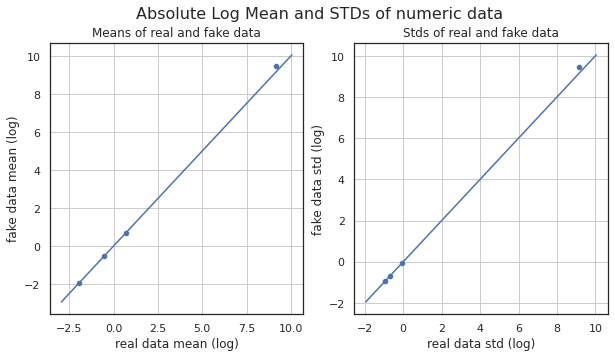

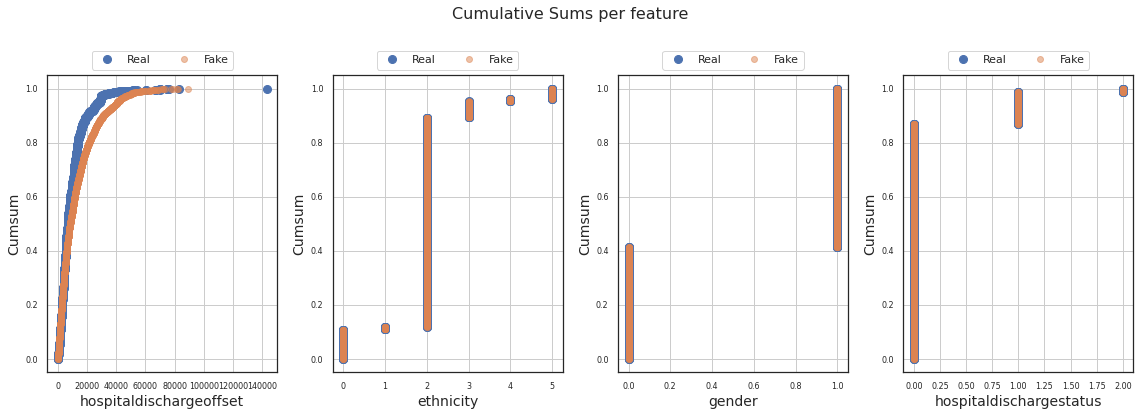

/home/dmf4ns/.local/lib/python3.9/site-packages/table_evaluator/table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})


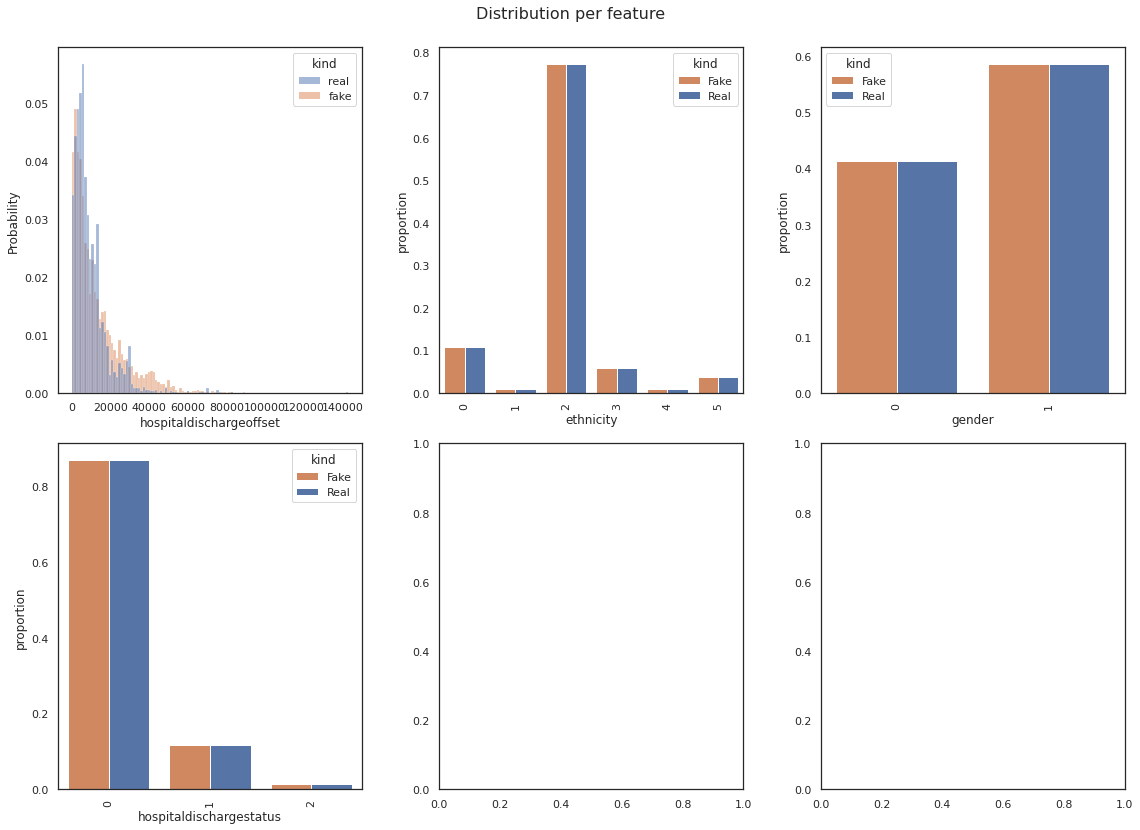

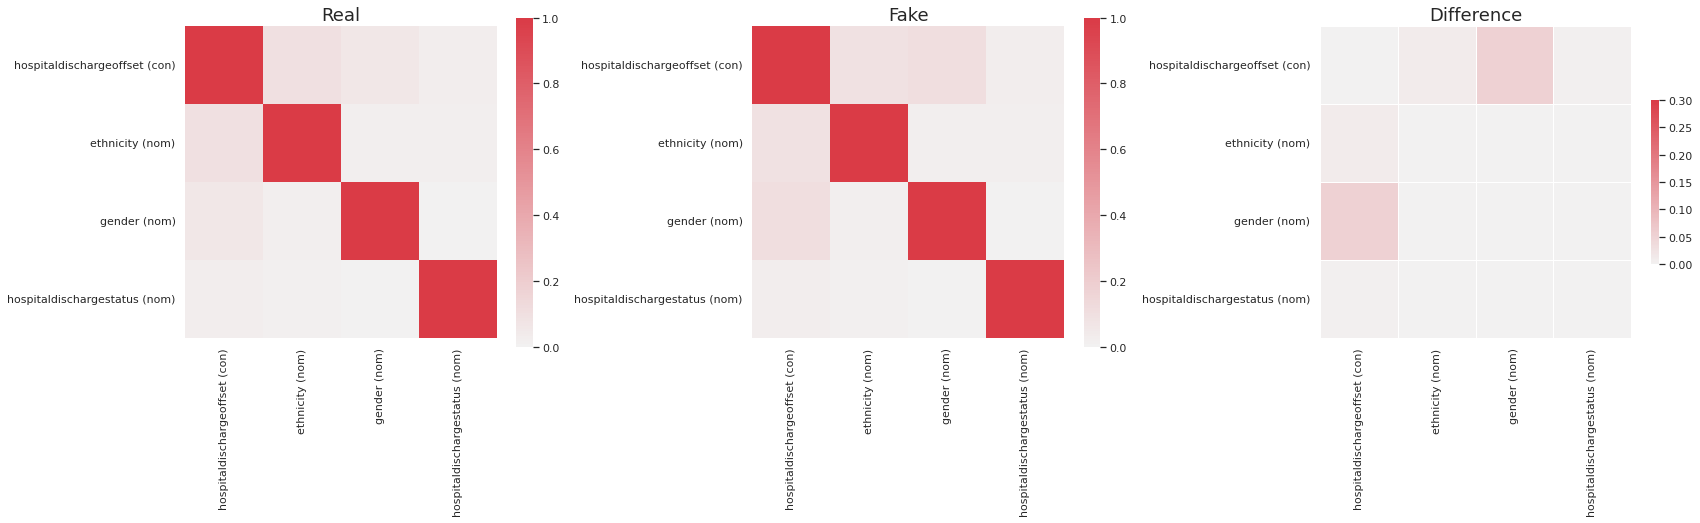

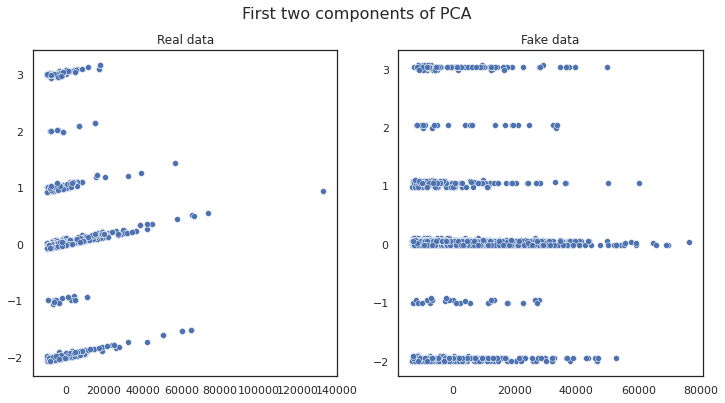

In [35]:
table_evaluator.visual_evaluation()